In [135]:
from Custom_tuning import *
from xgboost import XGBClassifier
import yfinance as yf
import pandas_ta as pta
from statsmodels.tsa.stattools import adfuller, kpss

In [136]:
df = pd.DataFrame()
tickers = ["AAPL", "^GSPC", "DX-Y.NYB"]
for ticker in tickers:
    data = yf.download(tickers=ticker, start="2020-04-01", end="2021-01-01", interval="1d")
    data[f"{ticker}_RSI"] = pta.rsi(data["Close"], length=7)
    data[f"{ticker}_WILLR"] = pta.willr(data["High"], data["Low"], data["Close"], length=7)
    data[f"{ticker}_SMA"] = pta.sma(data["Close"], length=7)
    data[f"{ticker}_ROC"] = pta.roc(data["Close"], length=7)
    data[f"{ticker}_CCI"] = pta.cci(data["High"], data["Low"], data["Close"], length=7)
    data[f"{ticker}_STOCH"] = pta.trima(data["Close"], length=7)
    if(ticker == "AAPL"):
        data["TARGET"] = data.apply(lambda x: 1 if x.Close > x.Open else 0, axis=1).shift(-1)
    data.rename(columns={"Close": f"{ticker}_Close"}, inplace=True)
    df = pd.concat([df, data], axis=1)
df.dropna(inplace=True)
df.drop(["Adj Close", "Open", "High", "Low", "Volume"], axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [137]:
def differencing(df, feature):
    data = df.copy()
    data[f"Diff_{feature}"] = data[feature].diff(periods=1)
    data.drop(feature, axis=1, inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data[f"Diff_{feature}"], marker=dict(color="blue"), mode="lines", name=f"Diff_{feature}"))
    fig.update_layout(template="simple_white", title=f"Diff_{feature}", title_x=0.5, width=600, height=600, showlegend=False, font=dict(family="Times New Roman",size=20,color="Black"))
    #fig.show("png")
    return data
X = df.drop("TARGET", axis=1)
y = df["TARGET"]
for feature in X.columns.tolist():
    X = differencing(df=X, feature=feature)
X.dropna(inplace=True)
y = y[1:]

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=17, test_size=0.2)

In [139]:
model = XGBClassifier(n_jobs=-1, random_state=17)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred), model.feature_importances_

(0.5405405405405406,
 array([0.08241507, 0.09753144, 0.02225322, 0.02158186, 0.02349612,
        0.03093831, 0.04312685, 0.06762404, 0.02247543, 0.06089779,
        0.04787246, 0.04037258, 0.05027352, 0.0312627 , 0.07164568,
        0.04875483, 0.05191742, 0.04165681, 0.04769883, 0.04120754,
        0.05499745], dtype=float32))

<BarContainer object of 21 artists>

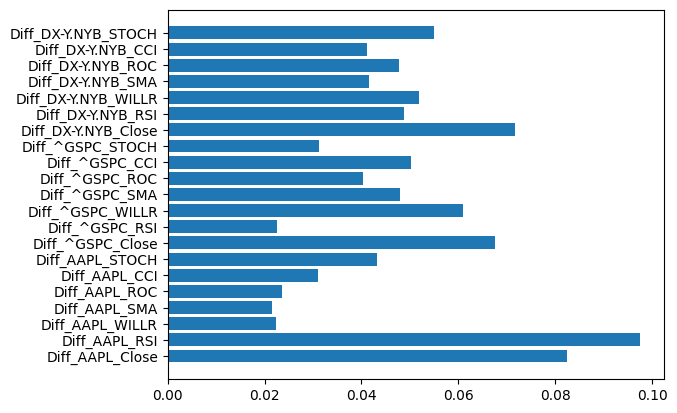

In [140]:
from matplotlib import pyplot as plt
plt.barh(X.columns, model.feature_importances_)

In [141]:
from sklearn.model_selection import TimeSeriesSplit
CV = Custom_Tuning_CV(metric="roc_auc", algorithm_instance=XGBClassifier(n_jobs=-1, random_state=17), cross_validation_instance=TimeSeriesSplit(n_splits=5), num_trials=100, random_state=17)
params_dict = {"n_estimators": ("int", [10, 500]),
                "learning_rate": ("float", [0.01, 0.8]),
                "reg_lambda": ("float", [0.1, 10]),
                "gamma": ("float", [0.1, 10]),
                "max_depth": ("int", [2, 50]),
                "colsample_bytree": ("float", [0.5, 1]),
                "subsample": ("float", [0.5, 1]),
                "min_child_weight": ("float", [0.5, 10])}
CV.fit(X=X_train, y=y_train, params_dict=params_dict)
CV.summary_frame_[:10]

,n_estimators,learning_rate,reg_lambda,gamma,max_depth,colsample_bytree,subsample,min_child_weight,Mean of Train ROC_AUC Scores,Mean of Valid ROC_AUC Scores
60,426,0.355200,0.619263,9.609060,17,0.502865,0.525566,2.984740,0.637898,0.619744
45,90,0.212695,0.456415,1.331680,30,0.527020,0.949524,8.559857,0.657722,0.603036
75,371,0.337594,1.772352,6.031306,21,0.732233,0.655132,1.093459,0.848113,0.599065
43,364,0.637623,3.334242,3.920260,15,0.928901,0.746339,4.995440,0.692422,0.595707
0,277,0.337193,3.103893,3.719672,13,0.883054,0.852110,6.783139,0.653742,0.595260
31,487,0.331643,6.205672,1.769444,47,0.575464,0.617814,5.699052,0.685776,0.592826
51,342,0.165560,8.107161,0.566111,19,0.509102,0.796547,7.847366,0.687051,0.584771
87,308,0.589363,5.574204,1.412434,30,0.518387,0.921122,8.178629,0.682005,0.584171
77,61,0.077106,5.905371,5.051398,7,0.906043,0.685042,5.192826,0.605322,0.580449
70,177,0.189612,5.111155,1.712290,38,0.989382,0.809312,5.140248,0.724347,0.578102


In [142]:
from tabulate import tabulate
final_algorithm_optimized = XGBClassifier(n_jobs=-1, random_state=1)
final_algorithm_optimized.set_params(**CV.best_params_)
final_algorithm_optimized.fit(X_train, np.array(y_train).squeeze())
y_pred_final_optimized = final_algorithm_optimized.predict(X_test)
y_prob_final_optimized = final_algorithm_optimized.predict_proba(X_test)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_final_optimized), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=y_prob_final_optimized), 5)))
report = classification_report(y_test, y_pred_final_optimized, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.47953
Roc AUC score: 0.42105
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0.0          |    0.444444 | 0.222222 |   0.296296 | 18        |
| 1.0          |    0.5      | 0.736842 |   0.595745 | 19        |
| accuracy     |    0.486486 | 0.486486 |   0.486486 |  0.486486 |
| macro avg    |    0.472222 | 0.479532 |   0.44602  | 37        |
| weighted avg |    0.472973 | 0.486486 |   0.450067 | 37        |
+--------------+-------------+----------+------------+-----------+
